In [74]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [75]:
if torch.backends.mps.is_available():
    device = torch.device('mps')  # Mac Metal Performance Shaders
    print(f"Training on device: {device} (Mac GPU)")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Training on device: {device} (NVIDIA GPU)")
else:
    device = torch.device('cpu')
    print(f"Training on device: {device} (CPU)")

print(f"PyTorch version: {torch.__version__}")
if device.type == 'mps':
    print("Using Mac Metal Performance Shaders for GPU acceleration")

print(f"PyTorch version: {torch.__version__}")
if device.type == 'mps':
    print("Using Mac Metal Performance Shaders for GPU acceleration")

Training on device: mps (Mac GPU)
PyTorch version: 2.9.0.dev20250704
Using Mac Metal Performance Shaders for GPU acceleration
PyTorch version: 2.9.0.dev20250704
Using Mac Metal Performance Shaders for GPU acceleration


In [76]:

class AttentionBlock(nn.Module):
    """Transformer layer for metabolic modeling"""
    def __init__(self,vocab_size=115,dim=6,num_heads=2):
        super(AttentionBlock, self).__init__()

        assert dim%num_heads==0, "model dimension must be divisible by number of heads"
        self.vocab_size = vocab_size
        self.d_model = dim
        
        self.layer_norm = nn.LayerNorm(dim)
        self.num_heads = num_heads
        self.k = dim//num_heads

        self.W_k = nn.Linear(dim,self.k,bias=False)
        self.W_q = nn.Linear(dim,self.k,bias=False)
        self.W_v = nn.Linear(dim,self.k,bias=False)
        self.W_o = nn.Linear(self.k,dim,bias=False)
        #self.W_c = nn.Linear(vocab_size,vocab_size,bias=False)

    def scaled_dot_product_attention(self,keys,queries,values):
        # Find the product if K and Q transpose and divide by the square root of the model dimension (d_model)

        pre_softmax_attention_matrix = torch.einsum('bij,bkj->bik', keys,queries)/np.sqrt(self.d_model)
        attention_matrix = torch.softmax(pre_softmax_attention_matrix,dim=-1)
        attention_output = torch.einsum( 'bij,bjk->bik' , attention_matrix, values)

        return attention_output, attention_matrix

    def forward(self,x,c):
        norm_x = self.layer_norm(x)
        #modified_c = self.W_c(c.transpose(-2,-1)).transpose(-2,-1)
        modified_c = c

        Q = self.W_k(norm_x)
        K = self.W_q(norm_x)
        V = self.W_v(norm_x)

        attention_output, attention_matrix = self.scaled_dot_product_attention(Q,K,V)

        #print(attention_matrix.size(),modified_c.size())

        attended_c = torch.einsum('bij,bjk->bik',attention_matrix,modified_c)
        
        #print(c.size(),attended_c.size())

        output_x = self.W_o(attention_output) + x*(1/self.num_heads)
        output_c = (attended_c + c)*(1/self.num_heads)

        return output_x, output_c


In [77]:

class MultiHeadAttentionBlock(nn.Module):
    """Multi-Head Attention layer for metabolic modeling"""
    def __init__(self,vocab_size=115,dim=6,num_heads=2):
        super(MultiHeadAttentionBlock, self).__init__()

        self.attention_blocks = nn.ModuleList([AttentionBlock(vocab_size,dim,num_heads) for _ in range(num_heads)])

    def forward(self,x,c):

        output_x = torch.zeros_like(x)
        output_c = torch.zeros_like(c)

        for attention_block in self.attention_blocks:
            o_x, o_c = attention_block(x,c)
            output_x += o_x
            output_c += o_c

        return output_x, output_c

        

In [78]:
class FeedForwardBlock(nn.Module):

    def __init__(self,d_model,inner_dim_multiplier,dropout=0.1):
        super(FeedForwardBlock, self).__init__()

        self.d_model = d_model+1
        self.inner_dim = inner_dim_multiplier*(d_model+1)

        self.layer_norm = nn.LayerNorm(self.d_model)

        self.linear_layer_1 = nn.Linear(self.d_model,self.inner_dim)
        self.linear_layer_2 = nn.Linear(self.inner_dim,self.d_model)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self,x,c):

        y = torch.cat((x,c),2)
        
        norm_y = self.layer_norm(y)
        
        norm_y = self.linear_layer_1(norm_y)
        norm_y = F.relu(norm_y)
        norm_y = self.linear_layer_2(norm_y)

        return norm_y + y

In [111]:

class TransformerBlock(nn.Module):
    """Embedding layer + Attention Block + FeedForward Layer"""
    def __init__(self,vocab_size=115,dim=6,num_heads=2,inner_dim_multiplier=5):
        super(TransformerBlock, self).__init__()

        self.d_model = dim
        self.vocab_size = vocab_size

        self.inp_embedding = nn.Embedding(vocab_size,dim)

        self.attention_block = AttentionBlock(vocab_size,dim,num_heads)

        self.feedforward_block = FeedForwardBlock(dim,inner_dim_multiplier)

        self.linear_layer_1 = nn.Linear(vocab_size,vocab_size)

        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    
    def forward(self,c):

        batch_size, vocab_size, _ = c.size()

        # y = torch.randint(0, vocab_size, (batch_size, vocab_size))
        # for k in range(vocab_size):
        #     y[:,k] = k

        y = torch.arange(vocab_size,device=device).unsqueeze(0).expand(batch_size, -1)
        
        x = self.inp_embedding(y)
        # print(x.size())
        
        output_x, output_c = self.attention_block(x,c)

        output_y = self.feedforward_block(output_x,output_c)

        return output_y[:,:,-1].unsqueeze(-1)

        #return output_c


In [79]:
class TransformersSeries(nn.Module):
    def __init__(self,vocab_size=115,dim=6,num_heads=2,inner_dim_multiplier=5,num_transformers=2):
        super(TransformersSeries, self).__init__()

        self.d_model = dim
        self.vocab_size = vocab_size
        self.num_transformers = num_transformers

        self.inp_embedding = nn.Embedding(vocab_size,dim)

        self.attention_blocks = nn.ModuleList([MultiHeadAttentionBlock(vocab_size,dim,num_heads) for _ in range(num_transformers)])

        self.feedforward_blocks = nn.ModuleList([FeedForwardBlock(dim,inner_dim_multiplier) for _ in range(num_transformers)])

        self.linear_layer_1 = nn.Linear(vocab_size,vocab_size)

        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    
    def forward(self,c):

        batch_size, vocab_size, _ = c.size()

        y = torch.arange(vocab_size,device=device).unsqueeze(0).expand(batch_size, -1)
        
        x = self.inp_embedding(y)

        
        # The series of transformer layers
        for i in range(self.num_transformers):

            output_x, output_c = self.attention_blocks[i](x,c)

            output_y = self.feedforward_blocks[i](output_x,output_c)

            x = output_y[:,:,:-1]
            c = output_y[:,:,-1].unsqueeze(-1)

        return output_y[:,:,-1].unsqueeze(-1)



Model loading module

In [80]:
vocab_size = 115
d_model=6
num_heads=2
inner_dim_multiplier=5
num_transformers=2

trained_model = TransformersSeries(vocab_size,d_model,num_heads,inner_dim_multiplier,num_transformers)

trained_model.load_state_dict(torch.load('trained_model.pth'))

<All keys matched successfully>

In [81]:
d_model_1 = 12
num_heads_1 = 3
inner_dim_multiplier_1 = 5

trained_model_12_3_5_2 = TransformersSeries(vocab_size,d_model_1,num_heads_1,inner_dim_multiplier,num_transformers)
trained_model_12_3_5_2.load_state_dict(torch.load('trained_model_12_3_5_2.pth'))



<All keys matched successfully>

Data loader

In [82]:
inps_test_ = torch.load('inputs_test.pt')
outs_test_ = torch.load('outputs_test.pt')

In [83]:
# inps_test_ = inps_test_.cpu()
# outs_test_ = inps_test_.cpu()

In [84]:
# Sanity Check on the test data
j = np.random.randint(0,inps_test_.size(0),1)[0]


In [85]:
trained_model.to(device)

TransformersSeries(
  (inp_embedding): Embedding(115, 6)
  (attention_blocks): ModuleList(
    (0-1): 2 x MultiHeadAttentionBlock(
      (attention_blocks): ModuleList(
        (0-1): 2 x AttentionBlock(
          (layer_norm): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
          (W_k): Linear(in_features=6, out_features=3, bias=False)
          (W_q): Linear(in_features=6, out_features=3, bias=False)
          (W_v): Linear(in_features=6, out_features=3, bias=False)
          (W_o): Linear(in_features=3, out_features=6, bias=False)
        )
      )
    )
  )
  (feedforward_blocks): ModuleList(
    (0-1): 2 x FeedForwardBlock(
      (layer_norm): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
      (linear_layer_1): Linear(in_features=7, out_features=35, bias=True)
      (linear_layer_2): Linear(in_features=35, out_features=7, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (linear_layer_1): Linear(in_features=115, out_features=115, bias=True)
)

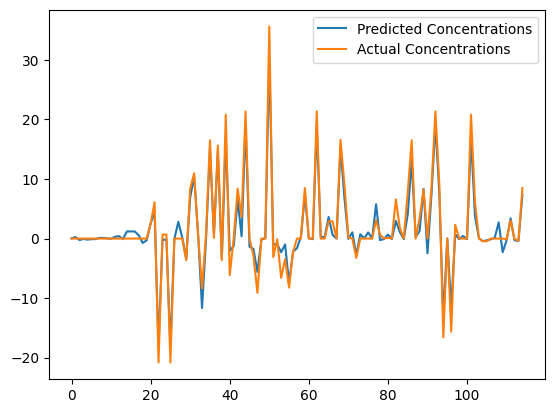

In [86]:
# Sanity Check on the test data
j = np.random.randint(0,inps_test_.size(0),1)[0]
pred_ops = trained_model(inps_test_[j,:,:].unsqueeze(0))
target_ops = outs_test_[j,:,:].unsqueeze(0)

plt.plot(pred_ops[0,:,0].cpu().detach().numpy(),label='Predicted Concentrations')
plt.plot(target_ops[0,:,0].cpu().detach().numpy(),label='Actual Concentrations')
plt.legend()
plt.show()

In [100]:
def plot_data(j):
    plt.figure(figsize=(12, 8))

    pred_ops = trained_model(inps_test_[j,:,:].unsqueeze(0))
    target_ops = outs_test_[j,:,:].unsqueeze(0)
    inputs = inps_test_[j,:,:].unsqueeze(0)
    plt.plot(pred_ops[0,:,0].cpu().detach().numpy(),color='red',label='Predicted Concentrations')
    plt.plot(target_ops[0,:,0].cpu().detach().numpy(),color='green',label='Actual Concentrations')
    plt.stem(inputs[0,:,0].cpu().detach().numpy(),label='Input Concentrations')
    plt.ylim([-60,100])
    plt.plot()
    plt.title(f"Test Simulation Number {j}")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
interactive_plot = interactive(plot_data, j=(0,inps_test_.size(0) - 1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=4977, description='j', max=9954), Output()), _dom_classes=('widget-inter…

In [89]:
trained_model_12_3_5_2.to(device)

TransformersSeries(
  (inp_embedding): Embedding(115, 12)
  (attention_blocks): ModuleList(
    (0-1): 2 x MultiHeadAttentionBlock(
      (attention_blocks): ModuleList(
        (0-2): 3 x AttentionBlock(
          (layer_norm): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
          (W_k): Linear(in_features=12, out_features=4, bias=False)
          (W_q): Linear(in_features=12, out_features=4, bias=False)
          (W_v): Linear(in_features=12, out_features=4, bias=False)
          (W_o): Linear(in_features=4, out_features=12, bias=False)
        )
      )
    )
  )
  (feedforward_blocks): ModuleList(
    (0-1): 2 x FeedForwardBlock(
      (layer_norm): LayerNorm((13,), eps=1e-05, elementwise_affine=True)
      (linear_layer_1): Linear(in_features=13, out_features=65, bias=True)
      (linear_layer_2): Linear(in_features=65, out_features=13, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (linear_layer_1): Linear(in_features=115, out_features=115, bias=Tr

In [118]:
def plot_data_1(j):
    plt.figure(figsize=(12, 8))

    pred_ops = trained_model_12_3_5_2(inps_test_[j,:,:].unsqueeze(0))
    target_ops = outs_test_[j,:,:].unsqueeze(0)
    inputs = inps_test_[j,:,:].unsqueeze(0)
    plt.plot(pred_ops[0,:,0].cpu().detach().numpy(),color='red',label='Predicted Concentrations')
    plt.plot(target_ops[0,:,0].cpu().detach().numpy(),color='green',label='Actual Concentrations')
    plt.stem(inputs[0,:,0].cpu().detach().numpy(),label='Input Concentrations')
    plt.ylim([-60,100])
    plt.title(f"Test Simulation Number {j}")
    plt.legend()
    plt.grid()
    plt.show()

In [119]:
interactive_plot = interactive(plot_data_1, j=(0,inps_test_.size(0) - 1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=4977, description='j', max=9954), Output()), _dom_classes=('widget-inter…

TransformerBlock(
  (inp_embedding): Embedding(115, 6)
  (attention_block): AttentionBlock(
    (layer_norm): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
    (W_k): Linear(in_features=6, out_features=6, bias=False)
    (W_q): Linear(in_features=6, out_features=6, bias=False)
    (W_v): Linear(in_features=6, out_features=6, bias=False)
    (W_o): Linear(in_features=6, out_features=6, bias=False)
  )
  (feedforward_block): FeedForwardBlock(
    (layer_norm): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
    (linear_layer_1): Linear(in_features=7, out_features=35, bias=True)
    (linear_layer_2): Linear(in_features=35, out_features=7, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (linear_layer_1): Linear(in_features=115, out_features=115, bias=True)
)